## Learning relations between tags 
 
 In this notebook we will test dofferent methods for learning relashions between tags 

In [17]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd 
import numpy as np
import pickle
import itertools

In [4]:
# ID schema (node2vec needs unique int IDs of nodes
# - **[0, 100,000]** - Goodreads book IDs
# - **[100,000 - 200,000]** - Tag IDs
# - **[200,000 - 300,000]** - DBPedia Nodes
# - **[1,000,000 - 1,100,000]** - Genre Nodes
# - **[1,100,000 - ....]** - Genre Classes Nodes
TAGS_ID_BEGIN = 100000
GENRES_ID_BEGIN = 1000000
GENRE_CLASSES_ID_BEGIN = 1100000
# Weight of the hard links
HARD_WEIGHT = 1000000

In [50]:
df_tags = pd.read_csv('data/tags_selected.csv', nrows=1000)

## 1. Turning tags into vectors with the help of Glove embeddings 

In [7]:
def generate_tokens(tag): 
    "Return tokens of the tag."
    tag = tag.replace("-", " ").replace("-", " ").replace("_", " ") #remove "-_"
    tag_tokens = tag.split() #remove multiple whitespaces 
    
    return tag_tokens

In [35]:
df_tags["tag_tokens"] = df_tags["tag_name"].apply(generate_tokens)
df_tags.head()

,tag_id,book_count,count,tag_name,tag_tokens
0,0,7,24,-,[]
1,1,2,6,--1-,[1]
2,15,2,6,--6-,[6]
3,21,2,19,-calif--,[calif]
4,22,3,27,-d-c--,"[d, c]"


In [6]:
embeddings_dict = {}
with open("..\glove.6B\glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [222]:
cos_sim(embeddings_dict['1'], embeddings_dict['4'])

0.8681426

In [224]:
cos_sim(embeddings_dict['1'], embeddings_dict['one'])

0.41719455

In [231]:
cos_sim(embeddings_dict['1920'], embeddings_dict['1920s'])

0.5829461

In [7]:
def tokens2avg_vec(tokens): 
    """Trnasorm list of tokens to an average embedding."""
    avg_vector = np.zeros(300)
    count = 0 
    for token in tokens:
        if token in embeddings_dict.keys(): 
            count+=1
            vector = embeddings_dict[token]
            avg_vector = np.add(avg_vector, vector) 
            
    if count==0: 
        return np.zeros(300)   
    
    avg_vector = np.true_divide(avg_vector, count)
                                    
    return avg_vector

In [8]:
def tokens2sum_vec(tokens): 
    """Trnasorm list of tokens to an average embedding."""
    sum_vector = np.zeros(300)
    count = 0 
    for token in tokens:
        if token in embeddings_dict.keys(): 
            count+=1
            vector = embeddings_dict[token]
            sum_vector = np.add(sum_vector, vector) 
            
    if count==0: 
        return np.zeros(300)   
                                    
    return sum_vector

In [189]:
df_tags["sum_vector"] = df_tags["tag_tokens"].apply(tokens2sum_vec)
df_tags["avg_vector"] = df_tags["tag_tokens"].apply(tokens2avg_vec)
df_tags.head()

C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector
0,0,7,24,-,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2,6,--1-,[1],"[-0.2867699861526489, 0.12257000058889389, 0.0...","[-0.2867699861526489, 0.12257000058889389, 0.0..."
2,15,2,6,--6-,[6],"[-0.28534001111984253, 0.11236999928951263, -0...","[-0.28534001111984253, 0.11236999928951263, -0..."
3,21,2,19,-calif--,[calif],"[0.1814499944448471, -0.7216899991035461, -0.3...","[0.1814499944448471, -0.7216899991035461, -0.3..."
4,22,3,27,-d-c--,"[d, c]","[-0.7629899680614471, -0.02555699646472931, -1...","[-0.38149498403072357, -0.012778498232364655, ..."


In [6]:
#coisne cimilarity
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b): 
    if (norm(a)*norm(b)) == 0: 
        return 0
    return dot(a, b)/(norm(a)*norm(b))

### Test on the test sample 

Now we will test relations learned with Glove embeddings and cosine similarity on the predefined sample test.

In [4]:
import pandas as pd
df_sample= pd.read_csv('test_data/tags_sample.csv')

In [37]:
df_sample["tag_tokens"] = df_sample["tag_name"].apply(generate_tokens)
# df_sample["sum_vector"] = df_sample["tag_tokens"].apply(tokens2sum_vec)
# df_sample["avg_vector"] = df_sample["tag_tokens"].apply(tokens2avg_vec)
df_sample.head()

,Unnamed: 0,tag_id,book_count,count,tag_name,clean_tag,bert_vector,tag_tokens
0,13450,28446,2,20,sports-romances,sports romances,"[0.17800267, -0.730618, -0.83565974, -0.455865...","[sports, romances]"
1,13451,28448,2,19,sports-star,sports star,"[-0.1889206, -0.45311016, -0.9630271, -0.26801...","[sports, star]"
2,13452,28450,3,30,sports-theme,sports theme,"[0.016484998, -0.25604492, 0.1521251, -0.72066...","[sports, theme]"
3,13453,28454,4,41,sporty,sporty,"[-0.028353646, -0.42307797, 0.14935729, -0.027...",[sporty]
4,13454,28456,3,24,spouses,spouses,"[0.16852805, -0.2436373, 0.32015175, 0.2433540...",[spouses]


In [20]:
file_sim_set = "test_data/simipar_tags_test_set.pickle"
file_all_set = "test_data/all_tags_test_set.pickle"

with open(file_sim_set, mode='rb') as f_sim:
    similar_set = pickle.load(f_sim)
    
with open(file_all_set, 'rb') as f_all:
    all_pairs_set = pickle.load(f_all)

In [21]:
not_similar_set =  all_pairs_set - similar_set

In [22]:
print("Similar pairs: ", len(similar_set))
print("All pairs: ", len(all_pairs_set))
print("Not similar pairs: ", len(not_similar_set))
print("percent in relation: ", len(similar_set) / len(all_pairs_set))

Similar pairs:  64
All pairs:  4950
Not similar pairs:  4886
percent in relation:  0.01292929292929293


In [18]:
def evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set):
    print("predicted similar: ", len(similar_pred))
    print("predicted not similar: ", len(not_similar_pred))
    
    TP_set = similar_pred & similar_set
    TP = len(TP_set)
    print("True positives: ", TP)
    
    FP_set = similar_pred - similar_set
    FP = len(FP_set)
    print("False positives: ", FP)
    
    TN_set = not_similar_pred & not_similar_set
    TN = len(TN_set)
    print("True negative: ", TN)
    
    FN_set = not_similar_pred - not_similar_set
    FN = len(FN_set)
    print("False negatives: ", FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = (2 * precision * recall) / (precision + recall)  
    
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", F1)
                            
    ALL_P = len(similar_pred)
    ALL_N = len(not_similar_pred)
    assert(TP + FP == ALL_P)
    assert(TN + FN == ALL_N)
    
    return TP_set, FP_set, TN_set, FN_set
    
    

In [19]:
def predict(df_sample, col_name, similarity_func, threshold):
    similar_pred = set()
    not_similar_pred = set()

    for pair in itertools.combinations(list(df_sample.index), 2):
        similarity = similarity_func(df_sample[col_name][pair[0]], 
                          df_sample[col_name][pair[1]])

        if similarity >threshold: 
            similar_pred.add((df_sample.tag_id[pair[0]], df_sample.tag_id[pair[1]]))

        else: 
            not_similar_pred.add((df_sample.tag_id[pair[0]], df_sample.tag_id[pair[1]]))
            
    return similar_pred, not_similar_pred 

In [27]:
similar_pred, not_similar_pred = predict(df_sample, col_name="sum_vector", similarity_func=cos_sim, threshold=0.75)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  198
predicted not similar:  4752
True positives:  46
False positives:  152
True negative:  4734
False negatives:  18
Precision:  0.23232323232323232
Recall:  0.71875
F1-score:  0.35114503816793896


In [28]:
similar_pred, not_similar_pred = predict(df_sample, col_name="sum_vector", similarity_func=cos_sim, threshold=0.80)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  113
predicted not similar:  4837
True positives:  39
False positives:  74
True negative:  4812
False negatives:  25
Precision:  0.34513274336283184
Recall:  0.609375
F1-score:  0.4406779661016949


In [60]:
similar_pred, not_similar_pred = predict(df_sample, col_name="sum_vector", similarity_func=cos_sim, threshold=0.75)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  198
predicted not similar:  4752
True positives:  46
False positives:  152
True negative:  4734
False negatives:  18
Precision:  0.23232323232323232
Recall:  0.71875
F1-score:  0.35114503816793896


In [32]:
similar_pred, not_similar_pred = predict(df_sample, col_name="avg_vector", similarity_func=cos_sim, threshold=0.90)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  21
predicted not similar:  4929
True positives:  11
False positives:  10
True negative:  4876
False negatives:  53
Precision:  0.5238095238095238
Recall:  0.171875
F1-score:  0.2588235294117647


In [33]:
similar_pred, not_similar_pred = predict(df_sample, col_name="avg_vector", similarity_func=cos_sim, threshold=0.80)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  113
predicted not similar:  4837
True positives:  39
False positives:  74
True negative:  4812
False negatives:  25
Precision:  0.34513274336283184
Recall:  0.609375
F1-score:  0.4406779661016949


In [248]:
#We can see that we have very low presision and recall with different thresholds and vector aggregation functions. 

In [42]:
df_tag_index = df_sample.set_index("tag_id", inplace=False)
df_tag_index.head()

,Unnamed: 0,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,elmo_vector
tag_id,,,,,,,,
28446,13450,2,20,sports-romances,"[sports, romances]","[0.0568699985742569, 0.39034000039100647, 0.54...","[0.02843499928712845, 0.19517000019550323, 0.2...","[-0.042172655, 0.39903176, 0.7187397, 0.349146..."
28448,13451,2,19,sports-star,"[sports, star]","[0.2612200006842613, 1.2325199842453003, 0.804...","[0.13061000034213066, 0.6162599921226501, 0.40...","[-0.024280027, 0.5228644, 0.051154897, 0.12639..."
28450,13452,3,30,sports-theme,"[sports, theme]","[-0.04677000641822815, 0.5131000131368637, -0....","[-0.023385003209114075, 0.25655000656843185, -...","[0.22847086, 0.8436613, 0.3412912, -0.31837714..."
28454,13453,4,41,sporty,[sporty],"[0.05509199947118759, -0.1198199987411499, -0....","[0.05509199947118759, -0.1198199987411499, -0....","[0.34459987, -0.2867304, 0.29648975, 0.4553322..."
28456,13454,3,24,spouses,[spouses],"[-0.17844000458717346, 0.1448100060224533, 0.1...","[-0.17844000458717346, 0.1448100060224533, 0.1...","[-0.9698962, 0.27260938, 0.39831045, -0.202134..."


In [41]:
def display(df_tag_index, pair_set):
    """Display the tag names in a set of tag pairs. """
    for pair in pair_set: 
        print(df_tag_index.loc[pair[0]]["tag_name"], df_tag_index.loc[pair[1]]["tag_name"])

In [36]:
print("True positives: ")
display(df_tag_index, TP_set)

True positives: 
steel--danielle steel-danielle
spy-books spy-novels
stage stage-play
star-wars star-wars-legends
star-wars star-wars-books
spy spy-espionage
star-wars star-wars-novels
spy spy-mystery
star-wars star-wars-read
spy spy-thriller
star-wars star-wars-universe
stand-alone stand-alones
spy spy-novel
star-wars star-wars-collection
star-wars star-wars-own
star-wars star-wars-owned
spy-books spy-fiction
spy spy-thriller-espionage
star-wars star-wars-to-read
spy-books spy-novel
star-wars star-wars-new-canon
star-wars star-wars-canon
spy-thriller spy-thriller-espionage
star-wars star-wars-old-republic-era
star-wars star-wars-expanded-universe
star-wars-cannon star-wars-canon
star-wars-books star-wars-novels
stand-alone stand-alone-books
star-wars star-wars-legends-novels
star-wars-own star-wars-owned
spy-novel spy-novels
spy spy-military
spy spy-thrillers
star-wars star-wars-cannon
started-but-didn-t-finish started-didn-t-finish
star-wars star-wars-eu
steinbeck steinbeck-john
spy 

In [37]:
print("False positives") #TODO: I clearly have mistake here 
display(df_tag_index, FP_set)

False positives
spy-fiction spy-novel
spy-mystery spy-novels
star-wars-canon star-wars-disney-canon
spy-fiction spy-thrillers
star-wars-own star-wars-to-read
star-wars-collection star-wars-legends
star-wars-books star-wars-legends-novels
star-wars-canon star-wars-read
star-wars-read star-wars-to-read
star-wars-canon star-wars-own
star-wars-new-canon star-wars-own
spy-mystery spy-thriller
spy-fiction spy-stories
star-wars-legends star-wars-legends-novels
star-wars-collection star-wars-novels
star-wars-books star-wars-expanded-universe
star-wars-collection star-wars-expanded-universe
spy-novels spy-stories
spy-fiction spy-mystery
star-wars-owned star-wars-read
star-wars-books star-wars-canon
steel steel--danielle
star-wars-cannon star-wars-universe
star-wars-cannon star-wars-own
star-wars-collection star-wars-legends-novels
spy-novels spy-thrillers
star-wars-books star-wars-to-read
star-wars-disney-canon star-wars-new-canon
star-wars-cannon star-wars-read
spy-novel spy-thriller
star-wars

In [38]:
print("False negatives") #TODO: I clearly have mistake here 
display(df_tag_index, FN_set)

False negatives
start-up start-ups
stage stage-dive
star-wars star-wars-disney-canon
started-but-didn-t-finish started-but-not-finished
steam-punk steampunk
spy spy-fiction
stark stark-trilogy
steel-danielle steele-danielle
stalker stalking
start-ups startups
steel--danielle steele-danielle
star-wars-eu star-wars-expanded-universe
stark stark-series
start-up startup
star-wars starwars
spy spy-kids
started-but-not-finished started-didn-t-finish
star_wars starwars
spy spy-books
spy spy-stories
starcrossed starcrossed-series
star-wars star_wars
spy spy-novels
spy spys
startup startups


In [39]:
#lets see in the bigger dataset 
count = 0
for pair in itertools.combinations(list(df_tags.index), 2):
    similarity = cos_sim(df_tags.avg_vector[pair[0]], 
                      df_tags.avg_vector[pair[1]])
    if similarity >=0.90: 
        print("ids: ", pair)
        print("tags: ", df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
        print("cosine similarity: ", similarity)
        count +=1  
    if count >=100: 
        break

ids:  (1, 30)
tags:  --1- 1
cosine similarity:  1.0
ids:  (1, 32)
tags:  --1- 1-12
cosine similarity:  0.921422956152739
ids:  (1, 196)
tags:  --1- 2
cosine similarity:  0.9279311107546221
ids:  (1, 2167)
tags:  --1- booklight-2
cosine similarity:  0.9279311107546221
ids:  (2, 32)
tags:  --6- 1-12
cosine similarity:  0.9008263071079576
ids:  (2, 369)
tags:  --6- 3
cosine similarity:  0.9210150373395274
ids:  (2, 392)
tags:  --6- 4
cosine similarity:  0.9594507330662714
ids:  (2, 394)
tags:  --6- 4-6
cosine similarity:  0.9897174210699152
ids:  (2, 409)
tags:  --6- 5
cosine similarity:  0.9642742288543533
ids:  (2, 434)
tags:  --6- 6
cosine similarity:  1.0
ids:  (2, 445)
tags:  --6- 7
cosine similarity:  0.9586908157343188
ids:  (2, 446)
tags:  --6- 7-9
cosine similarity:  0.949963411313848
ids:  (2, 447)
tags:  --6- 7-9-
cosine similarity:  0.949963411313848
ids:  (2, 456)
tags:  --6- 9
cosine similarity:  0.9183734637159392
ids:  (2, 458)
tags:  --6- 9-12
cosine similarity:  0.909148

KeyboardInterrupt: 

A problem that we can immediately notice is that Glove embeddings embed all the numbers with same vectors, which results in finding similarity between tags that are not semantically conneced. 

In [ ]:
# links_dict = dict()
# for id in df_tags.tag_id.values: 
#     links_dict[id] = [] 
# links_dict

# for pair in itertools.combinations(list(df_tags.index), 2):
#     similarity = cos_sim(df_tags.sum_vector[pair[0]], 
#                       df_tags.sum_vector[pair[1]])
#     if similarity >=0.90:
#         links_dict[df_tags.tag_id[pair[0]]].append(df_tags.tag_id[pair[1]])

In [ ]:
df_tags["tag_links"] = df_tags["tag_id"].apply(lambda x: links_dict[x])
df_tags.to_csv('tags_selected_links.csv', index=False)

In [ ]:
df_tags = pd.read_csv('data/tags_selected_links.csv')

In [ ]:
df_tags["links"] = df_tags["tag_links"].apply(lambda x: x != "[]")
df_tags.head()

In [ ]:
df_tags[1000:1100]

In [ ]:
#We have problem with the words that are nit in the vocabulary  

In [265]:
#Coverage  - was aroun 20% 
#len(df_tags[df_tags["links"] == True]) / len(df_tags)

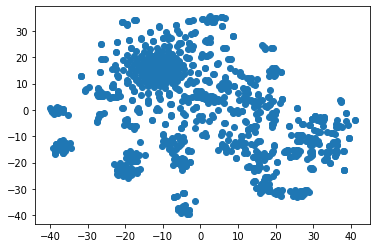

In [271]:
#Visualizing the vectors: 
tsne = TSNE(n_components=2, random_state=0)
vectors = list(df_tags.sum_vector.values)
tag_names = list(df_tags.tag_name.values)
Y = tsne.fit_transform(vectors[:1000])
plt.scatter(Y[:, 0], Y[:, 1])

## 2. Using fuzzy string matching 

In [40]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import itertools

C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [59]:
similar_pred, not_similar_pred = predict(df_sample, col_name="tag_name", similarity_func=fuzz.token_sort_ratio, threshold=75)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  68
predicted not similar:  4882
True positives:  23
False positives:  45
True negative:  4841
False negatives:  41
Precision:  0.3382352941176471
Recall:  0.359375
F1-score:  0.3484848484848485


In [41]:
similar_pred, not_similar_pred = predict(df_sample, col_name="tag_name", similarity_func=fuzz.token_sort_ratio, threshold=80)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  41
predicted not similar:  4909
True positives:  18
False positives:  23
True negative:  4863
False negatives:  46
Precision:  0.43902439024390244
Recall:  0.28125
F1-score:  0.34285714285714286


In [42]:
print("True positives: ")
display(df_tag_index, TP_set)

True positives: 
star-wars-cannon star-wars-canon
start-up start-ups
start-up startup
star-wars-own star-wars-owned
spy-novel spy-novels
steel-danielle steele-danielle
stand-alone stand-alones
star-wars starwars
start-ups startups
star_wars starwars
star-wars star_wars
steel--danielle steele-danielle
started-but-didn-t-finish started-didn-t-finish
spy spys
star-wars star-wars-eu
star-wars star-wars-own
steel--danielle steel-danielle
startup startups


In [43]:
print("False negatives: ")
display(df_tag_index, FN_set)

False negatives: 
spy-books spy-novels
star-wars star-wars-legends
stage stage-play
star-wars star-wars-books
spy spy-espionage
star-wars star-wars-novels
stage stage-dive
spy spy-mystery
star-wars star-wars-disney-canon
started-but-didn-t-finish started-but-not-finished
steam-punk steampunk
star-wars star-wars-read
spy spy-fiction
spy spy-thriller
stark stark-trilogy
stalker stalking
star-wars star-wars-universe
spy spy-novel
star-wars star-wars-collection
star-wars star-wars-owned
spy-books spy-fiction
spy spy-thriller-espionage
star-wars-eu star-wars-expanded-universe
stark stark-series
star-wars star-wars-to-read
spy-books spy-novel
star-wars star-wars-new-canon
spy spy-kids
started-but-not-finished started-didn-t-finish
star-wars star-wars-canon
spy-thriller spy-thriller-espionage
star-wars star-wars-old-republic-era
star-wars star-wars-expanded-universe
spy spy-books
star-wars-books star-wars-novels
spy spy-stories
starcrossed starcrossed-series
stand-alone stand-alone-books
star

In [47]:
print("False positives: ") #TODO: I clearly have mistake here 
display(df_tag_index, FP_set)

False positives: 
state states
steel steele
standalone standalones
spy-thriller spy-thrillers
states stats


In [51]:
fuzz.token_sort_ratio("star-wars", "star-wars-legends-novels")

55

In [46]:
similar_pred, not_similar_pred = predict(df_sample, col_name="tag_name", similarity_func=fuzz.token_sort_ratio, threshold=90)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  19
predicted not similar:  4931
True positives:  14
False positives:  5
True negative:  4881
False negatives:  50
Precision:  0.7368421052631579
Recall:  0.21875
F1-score:  0.3373493975903615


In [49]:
count = 0
for pair in itertools.combinations(list(df_tags.index), 2):
#     candidate = process.extractOne(tag, choices, scorer = fuzz.token_sort_ratio)
#     similarity = candidate[1]
    similarity = fuzz.token_sort_ratio(df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
    if similarity >=90: 
        print("ids: ", pair)
        print("tags: ", df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
        print("fuzzy token ratio: ", similarity)
        count +=1  
    if count >=100: 
        break

ids:  (1, 30)
tags:  --1- 1
fuzzy token ratio:  100
ids:  (2, 434)
tags:  --6- 6
fuzzy token ratio:  100
ids:  (3, 2612)
tags:  -calif-- calif
fuzzy token ratio:  100
ids:  (4, 3913)
tags:  -d-c-- d-c
fuzzy token ratio:  100
ids:  (5, 4077)
tags:  -dean dean
fuzzy token ratio:  100
ids:  (6, 5371)
tags:  -fictitious fictitious
fuzzy token ratio:  100
ids:  (7, 6129)
tags:  -gr- gr
fuzzy token ratio:  100
ids:  (8, 9058)
tags:  -mass-- mass
fuzzy token ratio:  100
ids:  (9, 9860)
tags:  -n-y-- n-y
fuzzy token ratio:  100
ids:  (10, 11271)
tags:  -post post
fuzzy token ratio:  100
ids:  (20, 7155)
tags:  03-informational informational
fuzzy token ratio:  90
ids:  (25, 28)
tags:  04-realistic-fiction 08-realistic-fiction
fuzzy token ratio:  95
ids:  (25, 11948)
tags:  04-realistic-fiction realistic-fiction
fuzzy token ratio:  92
ids:  (25, 11949)
tags:  04-realistic-fiction realistic-fiction-5
fuzzy token ratio:  92
ids:  (27, 9526)
tags:  07-modern-fantasy modern-fantasy
fuzzy token rati

In [ ]:
links_dict[df_tags.tag_id[pair[0]]].append(df_tags.tag_id[pair[1]])

In [25]:
fuzz.token_sort_ratio("started but did not finish", "started, didnt finnish")

77

## Creating new edges

In [42]:
df_tags_links = pd.read_csv('data_tags_selected_links.csv',
#                            converters={"tag_links": lambda x: x.strip("[]").replace("'","").split(", ")}
                           )
df_tags_links.head()

,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,tag_links
0,0,7,24,-,[],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[]
1,1,2,6,--1-,['1'],[-2.86769986e-01 1.22570001e-01 2.42209993e-...,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,"[134, 139, 560, 5084]"
2,15,2,6,--6-,['6'],[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,"[139, 982, 1056, 1061, 1110, 1178, 1207, 1209,..."
3,21,2,19,-calif--,['calif'],[ 1.81449994e-01 -7.21689999e-01 -3.77770007e-...,[ 1.81449994e-01 -7.21689999e-01 -3.77770007e-...,[6129]
4,22,3,27,-d-c--,"['d', 'c']",[-7.62989968e-01 -2.55569965e-02 -1.02808999e+...,[-3.81494984e-01 -1.27784982e-02 -5.14044993e-...,"[8794, 32207]"


In [43]:
len(df_tags_links)

16012

In [44]:
df_tags_links["tag_links"][0]

'[]'

In [45]:
df_links = df_tags_links[df_tags_links["tag_links"] != '[]'] 
df_links

,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,tag_links
1,1,2,6,--1-,['1'],[-2.86769986e-01 1.22570001e-01 2.42209993e-...,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,"[134, 139, 560, 5084]"
2,15,2,6,--6-,['6'],[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,"[139, 982, 1056, 1061, 1110, 1178, 1207, 1209,..."
3,21,2,19,-calif--,['calif'],[ 1.81449994e-01 -7.21689999e-01 -3.77770007e-...,[ 1.81449994e-01 -7.21689999e-01 -3.77770007e-...,[6129]
4,22,3,27,-d-c--,"['d', 'c']",[-7.62989968e-01 -2.55569965e-02 -1.02808999e+...,[-3.81494984e-01 -1.27784982e-02 -5.14044993e-...,"[8794, 32207]"
5,23,8,50,-dean,['dean'],[ 3.78859997e-01 8.28600004e-02 2.31470004e-...,[ 3.78859997e-01 8.28600004e-02 2.31470004e-...,"[9122, 9133]"
...,...,...,...,...,...,...,...,...
15768,33478,4,211,احمد-مراد,"['احمد', 'مراد']",[ 3.70000005e-02 -5.93410015e-01 2.15259999e-...,[ 3.70000005e-02 -5.93410015e-01 2.15259999e-...,[33700]
15778,33502,3,18,ادبیات-ایران,"['ادبیات', 'ایران']",[ 6.22349977e-01 3.17739993e-01 6.15270019e-...,[ 6.22349977e-01 3.17739993e-01 6.15270019e-...,[33609]
15823,33676,3,100,حسن-الجندى,"['حسن', 'الجندى']",[-1.64039999e-01 -4.75829989e-01 1.62870005e-...,[-1.64039999e-01 -4.75829989e-01 1.62870005e-...,[33677]
15839,33717,3,9,داستان-و-رمان,"['داستان', 'و', 'رمان']",[ 8.64289999e-02 -1.82050005e-01 1.63829997e-...,[ 8.64289999e-02 -1.82050005e-01 1.63829997e-...,"[33817, 34229]"


In [46]:
df_links["tag_links"] = df_links["tag_links"].apply(lambda x: x.strip("[]").replace("'","").split(", "))
df_links.head()

C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,tag_links
1,1,2,6,--1-,['1'],[-2.86769986e-01 1.22570001e-01 2.42209993e-...,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,"[134, 139, 560, 5084]"
2,15,2,6,--6-,['6'],[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,"[139, 982, 1056, 1061, 1110, 1178, 1207, 1209,..."
3,21,2,19,-calif--,['calif'],[ 1.81449994e-01 -7.21689999e-01 -3.77770007e-...,[ 1.81449994e-01 -7.21689999e-01 -3.77770007e-...,[6129]
4,22,3,27,-d-c--,"['d', 'c']",[-7.62989968e-01 -2.55569965e-02 -1.02808999e+...,[-3.81494984e-01 -1.27784982e-02 -5.14044993e-...,"[8794, 32207]"
5,23,8,50,-dean,['dean'],[ 3.78859997e-01 8.28600004e-02 2.31470004e-...,[ 3.78859997e-01 8.28600004e-02 2.31470004e-...,"[9122, 9133]"


In [47]:
#explode the tag links
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res
df_links = explode(df_links, ["tag_links"])

In [48]:
df_links.head()

,avg_vector,book_count,count,sum_vector,tag_id,tag_name,tag_tokens,tag_links
0,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,1,--1-,['1'],134
1,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,1,--1-,['1'],139
2,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,1,--1-,['1'],560
3,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,1,--1-,['1'],5084
4,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,2,6,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,15,--6-,['6'],139


In [49]:
TAGS_ID_BEGIN = 100000
def create_tag_id(tag_id):
    """Helper function for creating tag ids"""
    return tag_id + TAGS_ID_BEGIN
df_links["tag_id"] = df_links["tag_id"].apply(create_tag_id)

In [50]:
df_links["tag_links"] = df_links["tag_links"].apply(lambda x: int(x))
df_links["tag_links"] = df_links["tag_links"].apply(create_tag_id)

In [51]:
df_links.head()

,avg_vector,book_count,count,sum_vector,tag_id,tag_name,tag_tokens,tag_links
0,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,100001,--1-,['1'],100134
1,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,100001,--1-,['1'],100139
2,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,100001,--1-,['1'],100560
3,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,2,6,[-2.86769986e-01 1.22570001e-01 2.42209993e-...,100001,--1-,['1'],105084
4,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,2,6,[-2.85340011e-01 1.12369999e-01 -1.90799996e-...,100015,--6-,['6'],100139


In [85]:
tags_glove_edges = list(zip(list(df_links.tag_id.values), list(df_links.tag_links.values)))
tags_glove_edges_w = [(edge[0], edge[1], HARD_WEIGHT) for edge in tags_ids_edges]


[(100001, 100134, 1000000),
 (100001, 100139, 1000000),
 (100001, 100560, 1000000),
 (100001, 105084, 1000000),
 (100015, 100139, 1000000),
 (100015, 100982, 1000000),
 (100015, 101056, 1000000),
 (100015, 101061, 1000000),
 (100015, 101110, 1000000),
 (100015, 101178, 1000000),
 (100015, 101207, 1000000),
 (100015, 101209, 1000000),
 (100015, 101210, 1000000),
 (100015, 101247, 1000000),
 (100015, 101250, 1000000),
 (100021, 106129, 1000000),
 (100022, 108794, 1000000),
 (100022, 132207, 1000000),
 (100023, 109122, 1000000),
 (100023, 109133, 1000000),
 (100027, 111855, 1000000),
 (100030, 113466, 1000000),
 (100036, 119417, 1000000),
 (100038, 121052, 1000000),
 (100041, 124044, 1000000),
 (100041, 124055, 1000000),
 (100041, 124056, 1000000),
 (100043, 119177, 1000000),
 (100043, 125020, 1000000),
 (100134, 100139, 1000000),
 (100134, 100560, 1000000),
 (100134, 105084, 1000000),
 (100139, 100560, 1000000),
 (100139, 100982, 1000000),
 (100139, 101056, 1000000),
 (100139, 101061, 10

In [96]:
tags_glove_edges_w[-10:]

[(133423, 134229, 1000000),
 (133464, 133465, 1000000),
 (133477, 133478, 1000000),
 (133477, 133700, 1000000),
 (133478, 133700, 1000000),
 (133502, 133609, 1000000),
 (133676, 133677, 1000000),
 (133717, 133817, 1000000),
 (133717, 134229, 1000000),
 (133817, 134229, 1000000)]

In [87]:
def save_edges(edgelist, outfile, weights=False):
    """Write the edges in a file in a suitable for Node2vec form. """
    with open(outfile, "w+") as f:
        for edge in edgelist:
            f.write(str(edge[0]))
            f.write(" ")
            f.write(str(edge[1]))
            if weights:
                    f.write(" ")
                    f.write(str(edge[2]))
            f.write("\n")
           

In [88]:
save_edges(tags_ids_edges_w, "edges/tag_links_glove_90_w.edgelist", weights=True)

In [101]:
#load book to tag edges with weights 
book_to_tag_edges_w= list()
with open("edges/book_tags.edgelist", "r") as f: 
    for line in f: 
        weighted_edge = line.split()
        edge = (int(weighted_edge[0]),
                int(weighted_edge[1]), 
                 int(weighted_edge[2])
               ) 
        book_to_tag_edges_w.append(edge)

In [100]:
#load book to tag and genre edges with weights 
book_tag_class_edges_w= list()
with open("edges/book_tag_class_w.edgelist", "r") as f: 
    for line in f: 
        weighted_edge = line.split()
        edge = (int(weighted_edge[0]),
                int(weighted_edge[1]), 
                 int(weighted_edge[2])
               ) 
        book_tag_class_edges_w.append(edge)

In [102]:
len(book_tag_class_edges_w)

201087

In [103]:
concat_edges_w = book_tag_class_edges_w + tags_glove_edges_w

In [108]:
print("All egdes (book-tag, genre, tag-tag): ", len(concat_edges_w))

All egdes (book-tag, genre, tag-tag):  209627


In [104]:
concat_edges[-10:]

[(133423, 134229),
 (133464, 133465),
 (133477, 133478),
 (133477, 133700),
 (133478, 133700),
 (133502, 133609),
 (133676, 133677),
 (133717, 133817),
 (133717, 134229),
 (133817, 134229)]

In [109]:
print("Percent of growth of edges: ", len(concat_edges_w) / len(book_to_tag_edges))

Percent of growth of edges:  1.048135


In [110]:
save_edges(concat_edges_w, "edges/book_tag_genre_glove_90_w.edgelist", weights=True)

## 3. Using Elmo embeddings 

We will try to improve quality of embeddings by character-level embeddings 

In [29]:
import tensorflow as tf
import tensorflow_hub as hub

In [30]:
elmo_dir = "C:\\Users\\melania\\Documents\\Master-sеmester3\\Thesis - graph embeddings\\elmo_embeddings\\3"

In [21]:
df_sample.head()

,Unnamed: 0,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector
0,13450,28446,2,20,sports-romances,"[sports, romances]","[0.0568699985742569, 0.39034000039100647, 0.54...","[0.02843499928712845, 0.19517000019550323, 0.2..."
1,13451,28448,2,19,sports-star,"[sports, star]","[0.2612200006842613, 1.2325199842453003, 0.804...","[0.13061000034213066, 0.6162599921226501, 0.40..."
2,13452,28450,3,30,sports-theme,"[sports, theme]","[-0.04677000641822815, 0.5131000131368637, -0....","[-0.023385003209114075, 0.25655000656843185, -..."
3,13453,28454,4,41,sporty,[sporty],"[0.05509199947118759, -0.1198199987411499, -0....","[0.05509199947118759, -0.1198199987411499, -0...."
4,13454,28456,3,24,spouses,[spouses],"[-0.17844000458717346, 0.1448100060224533, 0.1...","[-0.17844000458717346, 0.1448100060224533, 0.1..."


In [47]:
tokens = [df_sample["tag_tokens"][0]]

In [48]:
tokens

[['sports', 'romances']]

In [31]:
elmo = hub.Module(elmo_dir, trainable=False)
# tokens_input = [["the", "cat", "is", "on", "the", "mat"],
# ["what", "are", "you", "doing", "in", "evening"]]
# tokens_length = [6, 5]
# embeddings = elmo(
# inputs={
# "tokens": tokens_input,
# "sequence_len": tokens_length
# },
# signature="tokens",
# as_dict=True)["elmo"]

In [32]:
def get_elmo_embedding(tokens): 
    tokens_input = [tokens]
    tokens_length = [len(tokens)]
    if len(tokens)==0: 
        return np.zeros(1024) 
    embeddings = elmo(
    inputs={
    "tokens": tokens_input,
    "sequence_len": tokens_length
    },
    signature="tokens",
    as_dict=True)["elmo"]
    
    tag_embeddings = session.run(embeddings)
     
    sum_embedding = sum(tag_embeddings[0])
    
    return sum_embedding   
    

In [33]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
#     df_sample["elmo_vector"] = df_sample["tag_tokens"].apply(get_elmo_embedding)
    emb1 = get_elmo_embedding(["startup"])
    emb2 = get_elmo_embedding(["startups"])
    print(cos_sim(emb1, emb2))
    emb1 = get_elmo_embedding(["spy"])
    emb2 = get_elmo_embedding(["spy", "novels"])
    print(cos_sim(emb1, emb2))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.741627
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.746793


In [64]:
df_tags = df_tags[:1000]
df_tags

,tag_id,book_count,count,tag_name,tag_tokens
0,0,7,24,-,[]
1,1,2,6,--1-,[1]
2,15,2,6,--6-,[6]
3,21,2,19,-calif--,[calif]
4,22,3,27,-d-c--,"[d, c]"
...,...,...,...,...,...
995,2545,179,3200,animal,[animal]
996,2548,9,112,animal-behavior,"[animal, behavior]"
997,2550,67,955,animal-books,"[animal, books]"
998,2554,33,469,animal-fantasy,"[animal, fantasy]"


In [35]:
df_sample

,Unnamed: 0,tag_id,book_count,count,tag_name,clean_tag,bert_vector
0,13450,28446,2,20,sports-romances,sports romances,"[0.17800267, -0.730618, -0.83565974, -0.455865..."
1,13451,28448,2,19,sports-star,sports star,"[-0.1889206, -0.45311016, -0.9630271, -0.26801..."
2,13452,28450,3,30,sports-theme,sports theme,"[0.016484998, -0.25604492, 0.1521251, -0.72066..."
3,13453,28454,4,41,sporty,sporty,"[-0.028353646, -0.42307797, 0.14935729, -0.027..."
4,13454,28456,3,24,spouses,spouses,"[0.16852805, -0.2436373, 0.32015175, 0.2433540..."
...,...,...,...,...,...,...,...
95,13545,28621,2,19,stegner,stegner,"[-0.072560154, -0.85100037, 0.19487262, -0.643..."
96,13546,28623,10,1322,steinbeck,steinbeck,"[-0.14187165, 0.6101422, -0.7491963, -0.857092..."
97,13547,28624,3,25,steinbeck-john,steinbeck john,"[-0.5703726, 1.03528, -1.5441835, -1.7505759, ..."
98,13548,28626,30,203,stem,stem,"[-0.9714799, -0.6297662, 0.086499184, -0.55872..."


In [38]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    df_sample["elmo_vector"] = df_sample["tag_tokens"].apply(get_elmo_embedding)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [68]:
#lets see in the bigger dataset 
count = 0
for pair in itertools.combinations(list(df_tags.index), 2):
    similarity = cos_sim(df_tags.elmo_vector[pair[0]], 
                      df_tags.elmo_vector[pair[1]])
    if similarity >=0.90: 
        print("ids: ", pair)
        print("tags: ", df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
        print("cosine similarity: ", similarity)
        count +=1  
    if count >=100: 
        break

AttributeError: 'DataFrame' object has no attribute 'elmo_vector'

In [36]:
df_sample.head()

,Unnamed: 0,tag_id,book_count,count,tag_name,clean_tag,bert_vector
0,13450,28446,2,20,sports-romances,sports romances,"[0.17800267, -0.730618, -0.83565974, -0.455865..."
1,13451,28448,2,19,sports-star,sports star,"[-0.1889206, -0.45311016, -0.9630271, -0.26801..."
2,13452,28450,3,30,sports-theme,sports theme,"[0.016484998, -0.25604492, 0.1521251, -0.72066..."
3,13453,28454,4,41,sporty,sporty,"[-0.028353646, -0.42307797, 0.14935729, -0.027..."
4,13454,28456,3,24,spouses,spouses,"[0.16852805, -0.2436373, 0.32015175, 0.2433540..."


In [48]:
similar_pred, not_similar_pred = predict(df_sample, col_name="elmo_vector", similarity_func=cos_sim, threshold=0.80)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  168
predicted not similar:  4782
True positives:  36
False positives:  132
True negative:  4754
False negatives:  28
Precision:  0.21428571428571427
Recall:  0.5625
F1-score:  0.31034482758620685


In [41]:
similar_pred, not_similar_pred = predict(df_sample, col_name="elmo_vector", similarity_func=cos_sim, threshold=0.75)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  265
predicted not similar:  4685
True positives:  50
False positives:  215
True negative:  4671
False negatives:  14
Precision:  0.18867924528301888
Recall:  0.78125
F1-score:  0.30395136778115506


In [49]:
print("True positives: ")
display(df_tag_index, TP_set)

True positives: 
steel--danielle steel-danielle
spy-books spy-novels
stage stage-play
star-wars star-wars-legends
star-wars star-wars-books
spy spy-espionage
start-up start-ups
star-wars star-wars-novels
stage stage-dive
spy spy-mystery
star-wars star-wars-disney-canon
star-wars star-wars-read
star-wars star-wars-universe
stand-alone stand-alones
star-wars star-wars-collection
star-wars star-wars-own
star-wars star-wars-owned
spy-books spy-fiction
star-wars star-wars-to-read
spy-books spy-novel
spy spy-kids
star-wars star-wars-canon
spy-thriller spy-thriller-espionage
star-wars-cannon star-wars-canon
star-wars-books star-wars-novels
stand-alone stand-alone-books
star-wars star-wars-legends-novels
star-wars-own star-wars-owned
spy-novel spy-novels
spy spy-military
star-wars star-wars-cannon
started-but-didn-t-finish started-didn-t-finish
star-wars star-wars-eu
steinbeck steinbeck-john
spy spy-action
spy spy-stuff


In [50]:
print("False neganives: ")
display(df_tag_index, FN_set)

False neganives: 
started-but-didn-t-finish started-but-not-finished
steam-punk steampunk
spy spy-fiction
spy spy-thriller
stark stark-trilogy
steel-danielle steele-danielle
stalker stalking
spy spy-novel
start-ups startups
steel--danielle steele-danielle
spy spy-thriller-espionage
star-wars-eu star-wars-expanded-universe
stark stark-series
start-up startup
star-wars star-wars-new-canon
star-wars starwars
started-but-not-finished started-didn-t-finish
star_wars starwars
star-wars star-wars-old-republic-era
star-wars star-wars-expanded-universe
spy spy-books
spy spy-stories
starcrossed starcrossed-series
spy spy-thrillers
star-wars star_wars
spy spy-novels
spy spys
startup startups


In [51]:
print("False positives: ")
display(df_tag_index, FP_set)

False positives: 
spy-fiction spy-novel
star-wars-disney-canon star-wars-own
star-wars-eu star-wars-legends
star-wars-canon star-wars-read
star-wars-disney-canon star-wars-universe
spy-espionage spy-stuff
star-wars-owned star-wars-read
star-wars-novels star-wars-to-read
star-wars-cannon star-wars-own
star-wars-legends-novels star-wars-universe
star-wars-disney-canon star-wars-new-canon
star-wars-legends star-wars-new-canon
spy-novel spy-thriller
star-wars-disney-canon star-wars-owned
spy-novels spy-thriller-espionage
star-wars-legends star-wars-owned
spy-kids spy-stuff
star-wars-books star-wars-universe
star-wars-disney-canon star-wars-legends-novels
spy-books spy-stories
star-wars-expanded-universe star-wars-universe
star-wars-collection star-wars-read
star-wars-canon star-wars-novels
star-wars-books star-wars-disney-canon
star-wars-own star-wars-universe
star-wars-read star-wars-universe
spy-mystery spy-stuff
spy-fiction spy-stuff
star-wars-disney-canon star-wars-eu
spy-stories spy-t

In [30]:
cos_sim(sum1, sum2)

0.9353844

In [29]:
sum2 = sum(message_embeddings2[0])
sum2

array([ 0.3310326 , -0.13125746, -1.049808  , ..., -2.2108836 ,
        0.55607057,  1.3907467 ], dtype=float32)

In [98]:
df_sample.to_csv("test_data/tags_sample_elmo_embeddings.csv")

## Clustering
In this section, we will look at how our vectors cluster together. 

In [70]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

In [71]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

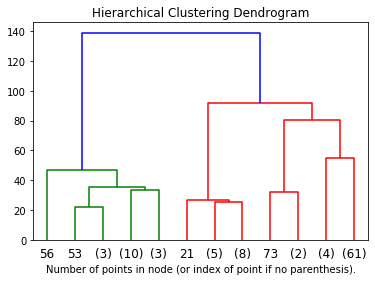

In [78]:
X = list(df_sample.elmo_vector.values)
model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [10]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# Compute DBSCAN
def evaluate_dbscan(X, eps=0.5, min_samples=10, metric='cosine'): 
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))
    
    return metrics.silhouette_score(X, labels), labels

In [153]:
X = list(df_sample.sum_vector.values)

In [164]:
# for eps in [0.1, 0.2, 0.3, 0.04, 0.05, 0.06, 0.25]:
#     print("eps : ", eps, "silhouette: ", evaluate_dbscan(X, eps=eps, min_samples=2, metric='cosine')[0])

In [177]:
evaluate_dbscan(X, eps=0.25, min_samples=2, metric='cosine')[1]

Estimated number of clusters: 10
Estimated number of noise points: 43
Silhouette Coefficient: 0.173


array([-1,  0, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  2,  2, -1, -1, -1,  3, -1,  3, -1,
       -1, -1, -1,  4,  4,  4,  4, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1,
       -1,  4,  4, -1,  5,  4,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  6,  6,  7,  7,  7,  8,  8, -1, -1,  9,  9, -1, -1],
      dtype=int64)

In [39]:
similar_pred, not_similar_pred = predict(df_sample, col_name="elmo_vector", similarity_func=cos_sim, threshold=0.90)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  22
predicted not similar:  4928
True positives:  9
False positives:  13
True negative:  4873
False negatives:  55
Precision:  0.4090909090909091
Recall:  0.140625
F1-score:  0.20930232558139533


In [184]:
df_sample["db_scan_labels"] = pd.Series(evaluate_dbscan(X, eps=0.20, min_samples=2, metric='cosine')[1])

Estimated number of clusters: 10
Estimated number of noise points: 48
Silhouette Coefficient: 0.155


In [325]:
for i in range(-1, 10): 
    print("cluster", i, ":", list(df_sample[df_sample["db_scan_labels"]==i]["tag_name"].values))   

cluster -1 : ['sports-romances', 'sports-theme', 'sporty', 'spouses', 'sprawl', 'spring', 'spritual', 'spys', 'squirrels', 'ss', 'stackhouse', 'staff-picks', 'stage-dive', 'stalker', 'stalking', 'stalled', 'stan-berenstain', 'standalone', 'standalones', 'star_wars', 'starcrossed', 'starcrossed-series', 'stargirl', 'stark', 'stark-series', 'stark-trilogy', 'start-up', 'start-ups', 'started', 'started-but-not-finished', 'starting-school', 'startup', 'startups', 'starwars', 'state', 'states', 'statistics', 'stats', 'stay-woke', 'stealing', 'steam-punk', 'steampunk', 'steele', 'steele-danielle', 'stefan-s-diaries', 'stegner', 'stem', 'stendhal']
cluster 0 : ['sports-star', 'star']
cluster 1 : ['spy', 'spy-action', 'spy-books', 'spy-espionage', 'spy-fiction', 'spy-kids', 'spy-military', 'spy-mystery', 'spy-novel', 'spy-novels', 'spy-stories', 'spy-stuff', 'spy-thriller', 'spy-thriller-espionage', 'spy-thrillers']
cluster 2 : ['sri', 'sri-lanka']
cluster 3 : ['stage', 'stage-play']
cluster 4

In [191]:
#On the whole dataset: 
X = list(df_tags.sum_vector.values)


In [361]:
# scores = [] 
# for eps in range(10, 30):
#     print(eps/100.0)
#     scores.append(evaluate_dbscan(X, eps/100.0, min_samples=2, metric='cosine')[0])

In [214]:
df_tags["db_scan_labels"] = pd.Series(evaluate_dbscan(X, eps=0.13, min_samples=2, metric='cosine')[1])

Estimated number of clusters: 68
Estimated number of noise points: 541
Silhouette Coefficient: -0.048


C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [383]:
df_tags.to_csv("tags_clusters_1000.csv")

In [372]:
for i in range(-1, 72): 
    print("cluster", i, ":", list(df_tags[df_tags["db_scan_labels"]==i]["tag_name"].values))

cluster -1 : ['-', '-calif--', '-d-c--', '-dean', '-fictitious', '-gr-', '-mass--', '-n-y--', '-post', '-read', '0', '0-owned', '00-in-class', '007', '01', '01-folklore', '02-fantasy', '02-words-sb', '03-informational', '04-babies-and-toddlers', '04-caldecott', '04-easy-to-read-books', '04-preschoolers', '06-traditional', '07-modern-fantasy', '0wn', '1-000-books-before-kindergarten', '1-ladies-detective-agency', '1-stephen-king', '1-to-sort', '1-year-challenge', '100', '1000-books', '1000-books-before-kindergarten', '1000-novels', '1001', '1001-challenge', '1001-import', '1001-libri-da-leggere', '1001books', '11-in-class', '110', '123', '15-16-school-year', '1500s', '1564-1616', '1775-1800', '1800', '1900', '1910s', '1915', '1919', '19th-c', '1q84', '1st-day-of-school', '2-non-fiction', '2000s', '2010s', '2012-dac', '2013-favorites', '2013-tob', '2014-favorites', '2014-movies', '2014-reads', '2015-2', '2015-challenge', '2015-favorites', '2015-publication', '2015-reads', '2015-tob', '20

cluster 51 : ['after-series', 'alchemyst-series']
cluster 52 : ['agatha-christie', 'agatha-christie-collection']
cluster 53 : ['age-3', 'age-4']
cluster 54 : ['ahlam', 'ahlam-mosteghanemi']
cluster 55 : ['ahmed', 'ahmed-khaled-tawfik', 'ahmed-khaled-tawfiq', 'ahmed-khaled-toufiq']
cluster 56 : ['albom', 'albom-mitch']
cluster 57 : ['alex-award', 'alex-awards']
cluster 58 : ['alex-rider', 'alex-rider-series']
cluster 59 : ['alpha', 'alpha-and-omega', 'alpha-and-omega-series', 'alpha-omega']
cluster 60 : ['alphabet-book', 'alphabet-books']
cluster 61 : ['amateur-detective', 'amateur-detectives']
cluster 62 : ['amazon-kindle', 'amazon-kindle-first']
cluster 63 : ['ancient', 'ancient-greece', 'ancient-greek', 'ancient-greek-literature', 'ancient-history', 'ancient-literature', 'ancient-texts']
cluster 64 : ['ancient-mysteries', 'ancient-mystery']
cluster 65 : ['angels', 'angels-and-demons', 'angels-demons']
cluster 66 : ['anglo-saxon', 'anglo-saxon-england']
cluster 67 : ['angstrom', 'angs

# Visualizing the vectors

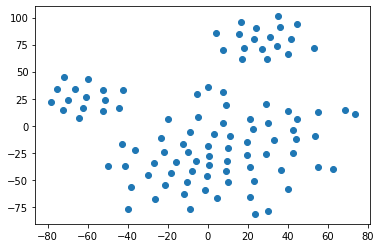

In [180]:
tsne = TSNE(n_components=2, random_state=0)
vectors = list(df_sample.sum_vector.values)
tag_names = list(df_sample.tag_name.values)
Y = tsne.fit_transform(vectors)
plt.scatter(Y[:, 0], Y[:, 1])

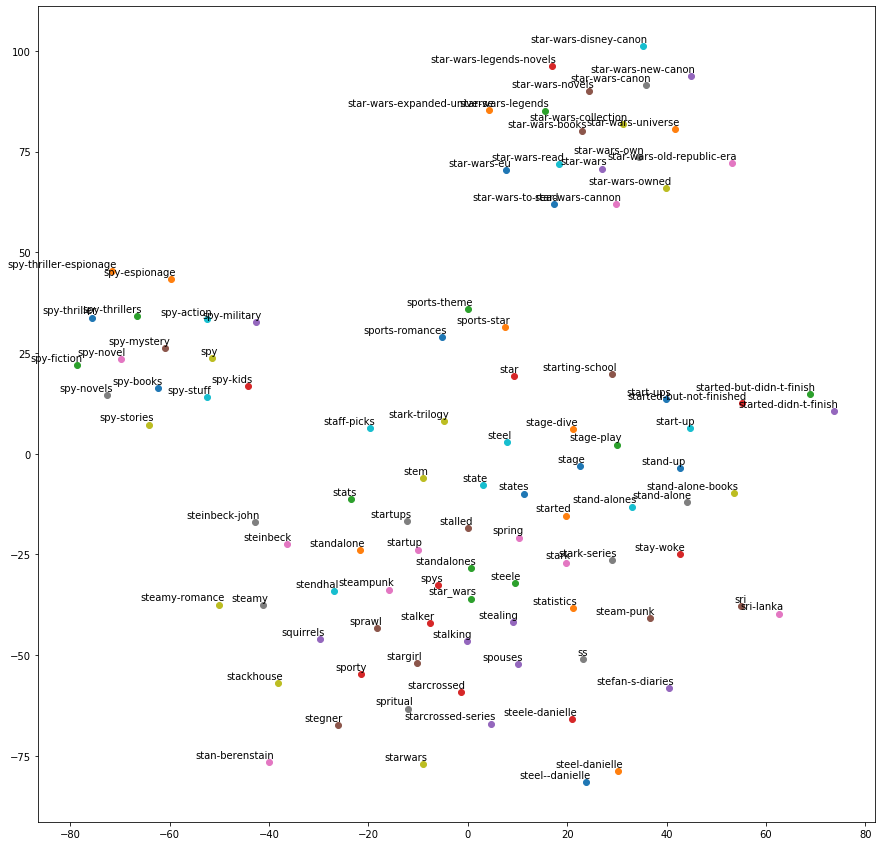

In [183]:
x = [] 
y = []
for value in Y:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(15, 15)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(tag_names[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig('../images/sample_vectors.png')
plt.show()

# BERT embeddings 

In [8]:
#TODO: see if I can use BERT the same way I use ELMO 

from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

In [51]:
df_tags

,tag_id,book_count,count,tag_name
0,0,7,24,-
1,1,2,6,--1-
2,15,2,6,--6-
3,21,2,19,-calif--
4,22,3,27,-d-c--
...,...,...,...,...
995,2545,179,3200,animal
996,2548,9,112,animal-behavior
997,2550,67,955,animal-books
998,2554,33,469,animal-fantasy


In [52]:
def clean_tag(tag): 
    "Preparing tag for forwarding it to the NED system."
    tag = tag.replace("-", " ").replace("_", " ") #remove "-_"
    tag = " ".join(tag.split()) #remove multiple whitespaces
    return tag

In [10]:
df_sample["clean_tag"] = df_sample["tag_name"].apply(clean_tag)
df_sample.head(2)

,Unnamed: 0,tag_id,book_count,count,tag_name,clean_tag
0,13450,28446,2,20,sports-romances,sports romances
1,13451,28448,2,19,sports-star,sports star


In [53]:
df_tags["clean_tag"] = df_tags["tag_name"].apply(clean_tag)
df_tags.head(2)

,tag_id,book_count,count,tag_name,clean_tag
0,0,7,24,-,
1,1,2,6,--1-,1


In [65]:
df_tags.replace(to_replace="", value="-", inplace=True)
df_tags

,tag_id,book_count,count,tag_name,clean_tag
0,0,7,24,-,-
1,1,2,6,--1-,1
2,15,2,6,--6-,6
3,21,2,19,-calif--,calif
4,22,3,27,-d-c--,d c
...,...,...,...,...,...
995,2545,179,3200,animal,animal
996,2548,9,112,animal-behavior,animal behavior
997,2550,67,955,animal-books,animal books
998,2554,33,469,animal-fantasy,animal fantasy


In [68]:
clean_tags = list(df_tags["clean_tag"].values)
result = bert_embedding(clean_tags)

In [90]:
examples = ["1-star", "4-star",  "-post", 
                          "post-apocolypse", "-read", "mangás-read",
                         "--1-",  "booklight-2", 
                         "1920", "1920s", 
                         "1-in-series", "20-in-series", "startup",  "startups", "spy", "spys", "spy",  "spy-novels"]
result2 = bert_embedding(examples)

In [91]:
bert_emb = [] 
for i in range(0, len(examples)): 
    emb = sum(result2[i][1])
    assert len(emb)==768
    bert_emb.append(emb)

In [92]:
for i in range(0, len(examples), 2): 
    print(examples[i], examples[i+1], cos_sim(bert_emb[i], bert_emb[i+1]))

1-star 4-star 0.90598834
-post post-apocolypse 0.32075635
-read mangás-read 0.704912
--1- booklight-2 0.5100419
1920 1920s 0.7554233
1-in-series 20-in-series 0.90099674
startup startups 0.5611763
spy spys 0.5874236
spy spy-novels 0.3281694


In [70]:
df_tags["bert_vector"] = pd.Series(bert_emb)
df_tags.head(2)

,tag_id,book_count,count,tag_name,clean_tag,bert_vector
0,0,7,24,-,-,"[0.08292842, -0.16572937, -0.07827371, -0.1370..."
1,1,2,6,--1-,1,"[-0.639723, -0.19626865, -0.30571342, -0.56380..."


In [71]:
count = 0
for pair in itertools.combinations(list(df_tags.index), 2):
    similarity = cos_sim(df_tags.bert_vector[pair[0]], 
                      df_tags.bert_vector[pair[1]])
    if similarity >=0.90: 
        print("ids: ", pair)
        print("tags: ", df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
        print("cosine similarity: ", similarity)
        count +=1  
    if count >=100: 
        break

ids:  (0, 463)
tags:  - _
cosine similarity:  1.0000001
ids:  (1, 30)
tags:  --1- 1
cosine similarity:  1.0000001
ids:  (2, 434)
tags:  --6- 6
cosine similarity:  1.0000001
ids:  (25, 28)
tags:  04-realistic-fiction 08-realistic-fiction
cosine similarity:  0.9060588
ids:  (35, 197)
tags:  1-in-series 2-in-series
cosine similarity:  0.94108933
ids:  (35, 396)
tags:  1-in-series 4-in-series
cosine similarity:  0.91681415
ids:  (35, 435)
tags:  1-in-series 6-in-series
cosine similarity:  0.9187372
ids:  (44, 48)
tags:  100-best-books 100-best-novels
cosine similarity:  0.956621
ids:  (45, 46)
tags:  100-best-books-of-all-time 100-best-books-of-all-time-the-worl
cosine similarity:  0.9248511
ids:  (48, 49)
tags:  100-best-novels 100-best-novels-list
cosine similarity:  0.9266861
ids:  (48, 58)
tags:  100-best-novels 100-greatest-novels
cosine similarity:  0.93785316
ids:  (53, 75)
tags:  100-books-to-read 1001-books-to-read
cosine similarity:  0.9290462
ids:  (54, 65)
tags:  100-books-to-r

In [27]:
similar_pred, not_similar_pred = predict(df_sample, col_name="bert_vector", similarity_func=cos_sim, threshold=0.90)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  33
predicted not similar:  4917
True positives:  9
False positives:  24
True negative:  4862
False negatives:  55
Precision:  0.2727272727272727
Recall:  0.140625
F1-score:  0.18556701030927833


In [24]:
similar_pred, not_similar_pred = predict(df_sample, col_name="bert_vector", similarity_func=cos_sim, threshold=0.80)
TP_set, FP_set, TN_set, FN_set = evaluate(similar_pred, not_similar_pred, similar_set, not_similar_set)

predicted similar:  199
predicted not similar:  4751
True positives:  34
False positives:  165
True negative:  4721
False negatives:  30
Precision:  0.1708542713567839
Recall:  0.53125
F1-score:  0.2585551330798479


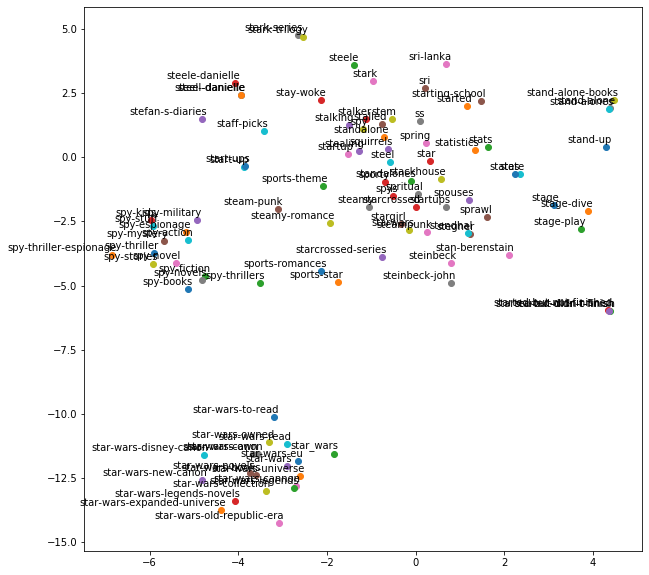

In [384]:
tsne = TSNE(n_components=2, random_state=0)
vectors = list(df_sample.bert_vector.values)
tag_names = list(df_sample.tag_name.values)
Y = tsne.fit_transform(vectors)
# plt.scatter(Y[:, 0], Y[:, 1])
x = [] 
y = []
for value in Y:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(10, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(tag_names[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig('../images/sample_vectors_bert.png')
plt.show()

In [18]:
X = list(df_sample.bert_vector.values)
evaluate_dbscan(X, eps=0.25, min_samples=2, metric='cosine')[0]

Estimated number of clusters: 10
Estimated number of noise points: 40
Silhouette Coefficient: 0.113


0.11266426

In [19]:
df_sample["db_scan_bert"] = pd.Series(evaluate_dbscan(X, eps=0.25, min_samples=2, metric='cosine')[1])

Estimated number of clusters: 10
Estimated number of noise points: 40
Silhouette Coefficient: 0.113


In [321]:
df_sample.head()

,Unnamed: 0,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,elmo_vector,db_scan_labels,clean_tag,bert_vector,db_scan_bert
0,13450,28446,2,20,sports-romances,"[sports, romances]","[0.0568699985742569, 0.39034000039100647, 0.54...","[0.02843499928712845, 0.19517000019550323, 0.2...","[-0.042172655, 0.39903176, 0.7187397, 0.349146...",-1,sports romances,"[0.17800267, -0.730618, -0.83565974, -0.455865...",0
1,13451,28448,2,19,sports-star,"[sports, star]","[0.2612200006842613, 1.2325199842453003, 0.804...","[0.13061000034213066, 0.6162599921226501, 0.40...","[-0.024280027, 0.5228644, 0.051154897, 0.12639...",0,sports star,"[-0.1889206, -0.45311016, -0.9630271, -0.26801...",-1
2,13452,28450,3,30,sports-theme,"[sports, theme]","[-0.04677000641822815, 0.5131000131368637, -0....","[-0.023385003209114075, 0.25655000656843185, -...","[0.22847086, 0.8436613, 0.3412912, -0.31837714...",-1,sports theme,"[0.016484998, -0.25604492, 0.1521251, -0.72066...",-1
3,13453,28454,4,41,sporty,[sporty],"[0.05509199947118759, -0.1198199987411499, -0....","[0.05509199947118759, -0.1198199987411499, -0....","[0.34459987, -0.2867304, 0.29648975, 0.4553322...",-1,sporty,"[-0.028353646, -0.42307797, 0.14935729, -0.027...",-1
4,13454,28456,3,24,spouses,[spouses],"[-0.17844000458717346, 0.1448100060224533, 0.1...","[-0.17844000458717346, 0.1448100060224533, 0.1...","[-0.9698962, 0.27260938, 0.39831045, -0.202134...",-1,spouses,"[0.16852805, -0.2436373, 0.32015175, 0.2433540...",-1


In [323]:
for i in range(-1, 10): 
    print("cluster", i, ":", list(df_sample[df_sample["db_scan_bert"]==i]["tag_name"].values))

cluster -1 : ['sports-star', 'sports-theme', 'sporty', 'spouses', 'sprawl', 'spring', 'spritual', 'squirrels', 'sri', 'sri-lanka', 'ss', 'stackhouse', 'staff-picks', 'stage', 'stage-dive', 'stage-play', 'stan-berenstain', 'stand-up', 'standalones', 'star', 'starcrossed', 'starcrossed-series', 'stargirl', 'stark', 'started', 'starting-school', 'startups', 'starwars', 'state', 'states', 'statistics', 'stats', 'stay-woke', 'steam-punk', 'steampunk', 'steel', 'steele', 'stefan-s-diaries', 'stegner', 'stendhal']
cluster 0 : ['sports-romances', 'spy-action', 'spy-books', 'spy-espionage', 'spy-fiction', 'spy-kids', 'spy-military', 'spy-mystery', 'spy-novel', 'spy-novels', 'spy-stories', 'spy-stuff', 'spy-thriller', 'spy-thriller-espionage', 'spy-thrillers', 'spys']
cluster 1 : ['spy', 'stalker', 'stalking', 'stalled', 'standalone', 'startup', 'stealing', 'stem']
cluster 2 : ['stand-alone', 'stand-alone-books', 'stand-alones']
cluster 3 : ['star-wars', 'star-wars-books', 'star-wars-cannon', 's

In [327]:
#On the tags: 
df_tags["clean_tag"] = df_tags["tag_name"].apply(clean_tag)
clean_tags = list(df_tags["clean_tag"].values)
result = bert_embedding(clean_tags)

C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [331]:
df_tags.head()

,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,db_scan_labels,clean_tag
0,0,7,24,-,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1,
1,1,2,6,--1-,[1],"[-0.2867699861526489, 0.12257000058889389, 0.0...","[-0.2867699861526489, 0.12257000058889389, 0.0...",0,1
2,15,2,6,--6-,[6],"[-0.28534001111984253, 0.11236999928951263, -0...","[-0.28534001111984253, 0.11236999928951263, -0...",0,6
3,21,2,19,-calif--,[calif],"[0.1814499944448471, -0.7216899991035461, -0.3...","[0.1814499944448471, -0.7216899991035461, -0.3...",-1,calif
4,22,3,27,-d-c--,"[d, c]","[-0.7629899680614471, -0.02555699646472931, -1...","[-0.38149498403072357, -0.012778498232364655, ...",-1,d c


In [332]:
sum(result[0][1])

0

In [345]:
bert_emb = [] 
for i in df_tags.index: 
    emb = sum(result[i][1])
    if type(emb)==int:
        bert_emb.append(np.zeros(768))
    else:
        bert_emb.append(emb)
df_tags["bert_vector"] = pd.Series(bert_emb)
df_tags.head(2)

C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tag_id,book_count,count,tag_name,tag_tokens,sum_vector,avg_vector,db_scan_labels,clean_tag,bert_vector
0,0,7,24,-,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2,6,--1-,[1],"[-0.2867699861526489, 0.12257000058889389, 0.0...","[-0.2867699861526489, 0.12257000058889389, 0.0...",0,1,"[-0.639723, -0.19626865, -0.30571342, -0.56380..."


In [346]:
X = list(df_tags["bert_vector"].values)

In [360]:
evaluate_dbscan(X, eps=0.20, min_samples=2, metric='cosine')[0]

Estimated number of clusters: 83
Estimated number of noise points: 340
Silhouette Coefficient: -0.113


-0.11287673666794758

In [381]:
df_tags["db_scan_bert"] = pd.Series(evaluate_dbscan(X, eps=0.20, min_samples=2, metric='cosine')[1])

Estimated number of clusters: 83
Estimated number of noise points: 340
Silhouette Coefficient: -0.113


C:\Users\melania\Anaconda3\envs\rec-sys-test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [382]:
for i in range(-1, 83): 
    print("cluster", i, ":", list(df_tags[df_tags["db_scan_bert"]==i]["tag_name"].values))   

cluster -1 : ['-', '-calif--', '-d-c--', '-fictitious', '-gr-', '-mass--', '-n-y--', '-post', '-read', '0', '0-owned', '007', '02-fantasy', '02-words-sb', '03-informational', '04-babies-and-toddlers', '04-caldecott', '04-preschoolers', '06-traditional', '0wn', '1-ladies-detective-agency', '1-stephen-king', '1-to-sort', '1-year-challenge', '100', '100-modern-library', '1001', '1001-challenge', '1001-kids-5plus', '1001-libri-da-leggere', '101st-airborne', '110', '15-16-school-year', '1564-1616', '1775-1800', '18', '1800', '1900', '1939-1945', '1958', '1974', '19th-c', '1q84', '1st-day-of-school', '2000s', '2012-dac', '2015-caudills', '2016-booker-longlist', '2018', '23-writing', '25-books-for-success', '2nd-chance', '3-considering', '3-food-healthy-life', '3-sports', '311', '325', '33-keepers', '39', '39-clues', '39-clues-cahills-vs-vespers', '39-clues-series', '4-6', '4hww', '50', '50-books-50-states', '50-shades', '50-shades-of-grey', '50-states', '500-women', '520-traditional-lit', '5

cluster 19 : ['18th', '19th', '20th', '21st']
cluster 20 : ['1915', '1919', '1961-1975', '1970-1979', '1971', '1978', '1979', '1980', '1980-1989', '1982', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1990-1999', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2000-2009', '2001', '2002', '2003', '2004', '2005', '2006']
cluster 21 : ['1920-s', '1930-s', '1960-s']
cluster 22 : ['1945', '1945-', '1946']
cluster 23 : ['1st', '4th', '5th']
cluster 24 : ['1st-quarter', '2nd-quarter', '3rd-quarter', '4th-quarter']
cluster 25 : ['2006-reads', '2008-books', '2008-reads', '2009-books', '2009-read', '2009-reads', '2010-books', '2010-read', '2010-reads', '2010-release', '2011-books', '2011-read', '2011-reads', '2011-release', '2011-releases', '2012-40-book-challenge', '2012-book-challenge', '2012-book-list', '2012-books', '2012-books-read', '2012-challenge', '2012-debut-author-challenge', '2012-forty-book-challenge', '2012-read', '2012-reading-challenge'

Bert embeddings are more spread into the vector space, and therefore, more tags are marked as noise.  

The problem with DBScan is that even there is one dot that is wrongly mapped beaing near two clucters of different concepts, the two clusters will then be merged.  

In [ ]:
#Last method that we will try is to see if the tokens for one of the tags are a subset of the tokens from another. 
#This will also be bad with numbers.  

In [38]:
df_tags

,tag_id,book_count,count,tag_name,tag_tokens
0,0,7,24,-,[]
1,1,2,6,--1-,[1]
2,15,2,6,--6-,[6]
3,21,2,19,-calif--,[calif]
4,22,3,27,-d-c--,"[d, c]"
...,...,...,...,...,...
16007,34239,5,31,日本,[日本]
16008,34241,5,31,日本語,[日本語]
16009,34242,16,64,漫画,[漫画]
16010,34247,5,353,Ｃhildrens,[Ｃhildrens]


In [41]:
def tokens_subset(tokens1, tokens2): 
    set_tokens1 = set(tokens1)
    set_tokens2 = set(tokens2)
    if len(tokens1)==0 or len(tokens2):
        return False 
    elif set_tokens1.issubset(set_tokens2) or set_tokens1.issubset(set_tokens2): 
        return True 
    else: 
        return False

In [47]:
count = 0
for pair in itertools.combinations(list(df_sample.index), 2):
#     candidate = process.extractOne(tag, choices, scorer = fuzz.token_sort_ratio)
#     similarity = candidate[1]
#     similarity = fuzz.token_sort_ratio(df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
#     if similarity >=90: 
#         print("ids: ", pair)
#         print("tags: ", df_tags.tag_name[pair[0]], df_tags.tag_name[pair[1]])
#         print("fuzzy token ratio: ", similarity)
#         count +=1  
    is_subset = tokens_subset(df_sample.tag_tokens[pair[0]], df_sample.tag_tokens[pair[1]])
    if is_subset: 
        print("tags: ", df_sample.tag_name[pair[0]], df_sample.tag_name[pair[1]])
        count +=1
    if count >=100: 
        break

In [ ]:
#TODO: за всеки клъстер, вземи тага, който е най-общ, и го определи като "тема" на клъстера, 
#всички тагове, които не се срещат заедно с него, махни от клъстера. Ако са повече от N=1 (примерно), формирай нов клъстер. 



In [23]:
X[0].shape

(768,)

In [39]:
#TODO: try probably agglomerative clustering 
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(distance_threshold=40, n_clusters=None).fit(X)
labels = clustering.labels_
n_clusters = clustering.n_clusters_
print(labels, n_clusters)

[0 0 3 2 2 2 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 0 2 2 2 4 2 2 3 2 4 4 2 2 2 0
 0 0 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 2 3 2 2 3 3 0 0 2 6 6
 6 0 2 2 2 2 2 2 2 2 2 3 2 2 3 2 3 3 2 3 3 2 3 3 2 2] 8


In [43]:
df_sample["hac_bert"] = pd.Series(labels)
for i in range(-1, 83): 
    print("cluster", i, ":", list(df_sample[df_sample["hac_bert"]==i]["tag_name"].values))  

cluster -1 : []
cluster 0 : ['sports-romances', 'sports-star', 'spy-thrillers', 'stan-berenstain', 'stand-alone', 'stand-alone-books', 'stand-alones', 'stand-up', 'start-up', 'start-ups', 'starting-school']
cluster 1 : ['star-wars', 'star-wars-books', 'star-wars-cannon', 'star-wars-canon', 'star-wars-collection', 'star-wars-disney-canon', 'star-wars-eu', 'star-wars-expanded-universe', 'star-wars-legends', 'star-wars-legends-novels', 'star-wars-new-canon', 'star-wars-novels', 'star-wars-own', 'star-wars-owned', 'star-wars-read', 'star-wars-to-read', 'star-wars-universe', 'star_wars']
cluster 2 : ['sporty', 'spouses', 'sprawl', 'spring', 'spritual', 'spy', 'spys', 'squirrels', 'sri', 'ss', 'stackhouse', 'stage', 'stalker', 'stalking', 'stalled', 'standalone', 'standalones', 'star', 'starcrossed', 'stargirl', 'stark', 'started', 'startup', 'startups', 'starwars', 'state', 'states', 'statistics', 'stats', 'stay-woke', 'stealing', 'steampunk', 'steamy', 'steel', 'steele', 'stegner', 'stem',